# FINAL PROJECT: UNPROCESSED vs PROCESSED

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import time

# 1. LOAD DATA

In [19]:
print("Loading datasets...")
# We assume training.csv contains ALL the 'before cleaning' columns
train_raw = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/training/training.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/test/test.csv')

train_raw_cleaned = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/training/training_cleaned.csv')
test_raw_cleaned = pd.read_csv('/content/drive/MyDrive/MLProject/data/recommended/test/test_cleaned.csv')

Loading datasets...


# SCENARIO A: THE "UNPROCESSED" APPROACH (Naive)

In [20]:
print("\n" + "="*40)
print("RUNNING SCENARIO A: UNPROCESSED DATA")
print("="*40)
print("Using raw columns including IDs and IPs (Potential Data Leakage)...")



RUNNING SCENARIO A: UNPROCESSED DATA
Using raw columns including IDs and IPs (Potential Data Leakage)...


##  1. Define 'Unprocessed' Columns




In [21]:
cols_unprocessed = [
    'pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'state_number',
    'seq', 'mean', 'stddev', 'min', 'max', 'srate', 'drate',
    'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP', 'category'
]

# Select these columns
X_train_unproc = train_raw[cols_unprocessed].copy()
X_test_unproc = test_raw[cols_unprocessed].copy()

## 2. Naive Encoding (Lazy Approach)

In [22]:
# We just turn every text string into a number so XGBoost doesn't crash.
# We do NOT remove IDs or IPs.
le_dict = {}

# Separate Target
y_train_unproc = X_train_unproc.pop('category')
y_test_unproc = X_test_unproc.pop('category')

# Encode Target
le_target_unproc = LabelEncoder()
y_train_unproc = le_target_unproc.fit_transform(y_train_unproc)
y_test_unproc = le_target_unproc.transform(y_test_unproc)

# Encode Features (Blindly encode everything that is Object type)
for col in X_train_unproc.columns:
    if X_train_unproc[col].dtype == 'object':
        le = LabelEncoder()
        # Combine to fit (handle unknown labels simply for this demo)
        combined_data = pd.concat([X_train_unproc[col], X_test_unproc[col]]).astype(str)
        le.fit(combined_data)
        X_train_unproc[col] = le.transform(X_train_unproc[col].astype(str))
        X_test_unproc[col] = le.transform(X_test_unproc[col].astype(str))


## 3. Train "Unprocessed" Model

In [23]:
print("Training Unprocessed Model...")
start_time = time.time()
model_unproc = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    device="cuda",
    random_state=42
)
model_unproc.fit(X_train_unproc, y_train_unproc)
time_unproc = time.time() - start_time

Training Unprocessed Model...


## 4. Evaluate

In [24]:
acc_unproc = accuracy_score(y_test_unproc, model_unproc.predict(X_test_unproc))
print(f"Unprocessed Accuracy: {acc_unproc:.4f}")
print("(Warning: High accuracy here might indicate overfitting to Row IDs or IPs)")

Unprocessed Accuracy: 1.0000
(Warning: High accuracy here might indicate overfitting to Row IDs or IPs)


# SCENARIO B: THE "PROCESSED" APPROACH (Clean)

In [25]:
print("\n" + "="*40)
print("RUNNING SCENARIO B: PROCESSED DATA")
print("="*40)


RUNNING SCENARIO B: PROCESSED DATA


## 1. Define 'Processed' Columns

In [26]:
cols_processed = [
    'pkSeqID', 'proto', 'sport', 'dport', 'state_number',
    'mean', 'stddev', 'min', 'max', 'srate', 'drate',
    'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP', 'category'
]

# Select columns
X_train_proc = train_raw_cleaned[cols_processed].copy()
X_test_proc = test_raw_cleaned[cols_processed].copy()


## 2. PRE-PROCESSING (The "Clean" Steps)

In [27]:
print("Applying Cleaning Steps...")

Applying Cleaning Steps...


### A. Handle Ports (Force to numeric, fix hex issues)

In [28]:
for col in ['sport', 'dport']:
    X_train_proc[col] = pd.to_numeric(X_train_proc[col], errors='coerce').fillna(0)
    X_test_proc[col] = pd.to_numeric(X_test_proc[col], errors='coerce').fillna(0)

### B. Drop Identifiers (Crucial Step: Removing pkSeqID)

In [29]:
# We kept it in the list to load it, but we drop it for training to avoid cheating.
X_train_proc = X_train_proc.drop(columns=['pkSeqID'])
X_test_proc = X_test_proc.drop(columns=['pkSeqID'])

# Separate Target
y_train_proc = X_train_proc.pop('category')
y_test_proc = X_test_proc.pop('category')

### C. Proper Encoding

In [30]:
le_target_proc = LabelEncoder()
# Fit on combined to know all classes
le_target_proc.fit(pd.concat([y_train_proc, y_test_proc]))
y_train_proc = le_target_proc.transform(y_train_proc)
y_test_proc = le_target_proc.transform(y_test_proc)

# One-Hot Encode Protocol
X_train_proc = pd.get_dummies(X_train_proc, columns=['proto'], drop_first=True)
X_test_proc = pd.get_dummies(X_test_proc, columns=['proto'], drop_first=True)
# Align
X_train_final, X_test_final = X_train_proc.align(X_test_proc, join='left', axis=1, fill_value=0)


## 3. Hyperparameter Tuning using Randomized Search (Exploration)

In [31]:
print("\n[Phase 1] Running Randomized Search (Exploring broad parameters)...")

# Wide range of parameters
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.5]
}

xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target_proc.classes_),
    device="cuda",
    n_jobs=-1,
    random_state=42
)

# n_iter=15 means "Try 15 random combinations"
random_search = RandomizedSearchCV(xgb_base, param_distributions=param_dist, n_iter=15, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train_final, y_train_proc)

print(f"Best Random Search Params: {random_search.best_params_}")
print(f"Best Random Search Score: {random_search.best_score_:.4f}")


[Phase 1] Running Randomized Search (Exploring broad parameters)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Search Params: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.9}
Best Random Search Score: 0.9982


## 4. Hyperparameter Tuning using Grid Search

In [32]:
print("\n[Phase 2] Running Grid Search (Fine tuning best findings)...")

# We take the best learning rate and depth from RandomSearch and check neighbors
best_lr = random_search.best_params_['learning_rate']
best_depth = random_search.best_params_['max_depth']

# Create a focused grid around the winner
param_grid = {
    'n_estimators': [200],  # Lock this to save time
    'max_depth': [best_depth, best_depth + 2],
    'learning_rate': [best_lr, best_lr * 0.5] # Try the winner and a smaller step
}

grid_search = GridSearchCV(xgb_base, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_final, y_train_proc)

best_model = grid_search.best_estimator_
print(f"Best Grid Search Params: {grid_search.best_params_}")


[Phase 2] Running Grid Search (Fine tuning best findings)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Grid Search Params: {'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200}


# COMPARISON & VISUALIZATION

In [33]:
print("FINAL RESULTS")
print("="*40)

# Predict
y_pred_final = best_model.predict(X_test_final)
acc_proc = accuracy_score(y_test_proc, y_pred_final)

# Compare
print(f"Unprocessed Accuracy: {acc_unproc:.4f}")
print(f"Processed (Tuned) Accuracy: {acc_proc:.4f}")

FINAL RESULTS
Unprocessed Accuracy: 1.0000
Processed (Tuned) Accuracy: 0.9982


### 1. CONFUSION MATRIX (Side-by-Side)

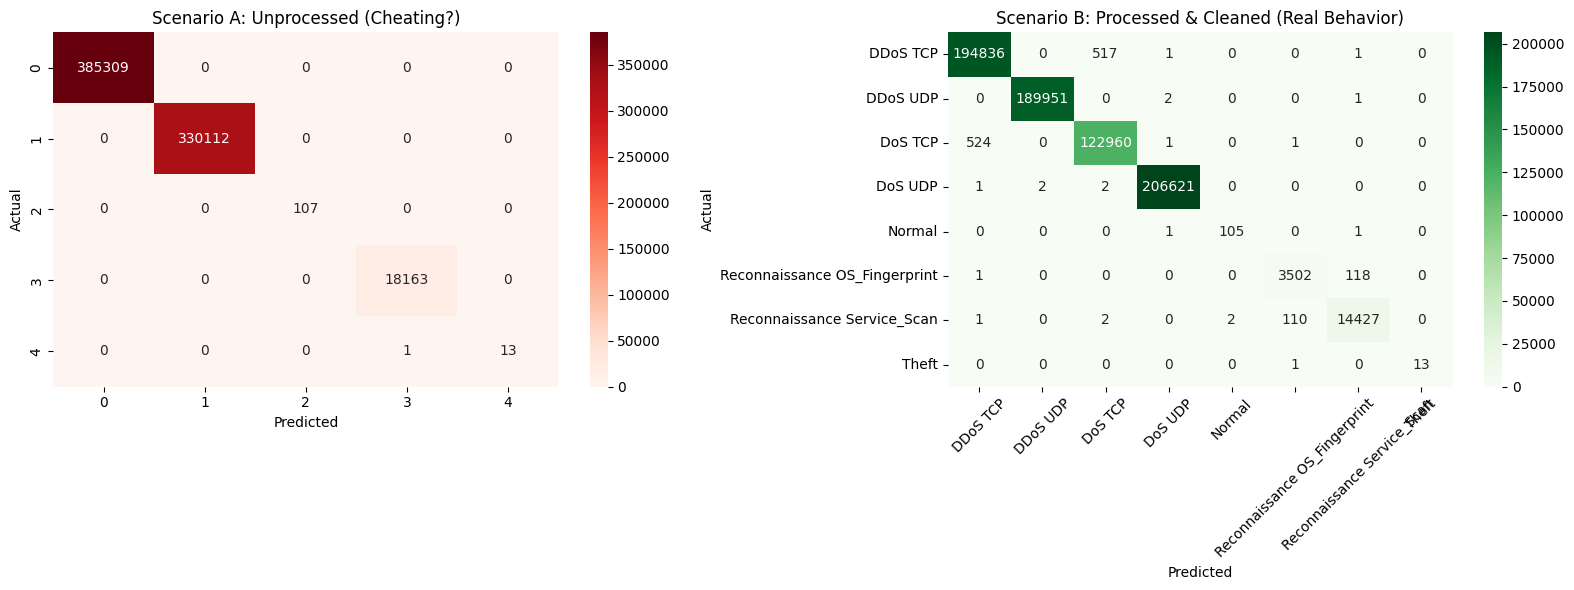

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Unprocessed Matrix
cm_unproc = confusion_matrix(y_test_unproc, model_unproc.predict(X_test_unproc))
sns.heatmap(cm_unproc, annot=True, fmt='d', cmap='Reds', ax=axes[0])
axes[0].set_title('Scenario A: Unprocessed (Cheating?)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Processed Matrix
cm_proc = confusion_matrix(y_test_proc, best_model.predict(X_test_final))
sns.heatmap(cm_proc, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_target_proc.classes_,
            yticklabels=le_target_proc.classes_, ax=axes[1])
axes[1].set_title('Scenario B: Processed & Cleaned (Real Behavior)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2. CLASSIFICATION REPORT

In [35]:
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (PROCESSED MODEL)")
print("="*50)
y_pred_final = best_model.predict(X_test_final)
print(classification_report(le_target_proc.inverse_transform(y_test_proc),
                            le_target_proc.inverse_transform(y_pred_final)))


DETAILED CLASSIFICATION REPORT (PROCESSED MODEL)
                               precision    recall  f1-score   support

                     DDoS TCP       1.00      1.00      1.00    195355
                     DDoS UDP       1.00      1.00      1.00    189954
                      DoS TCP       1.00      1.00      1.00    123486
                      DoS UDP       1.00      1.00      1.00    206626
                       Normal       0.98      0.98      0.98       107
Reconnaissance OS_Fingerprint       0.97      0.97      0.97      3621
  Reconnaissance Service_Scan       0.99      0.99      0.99     14542
                        Theft       1.00      0.93      0.96        14

                     accuracy                           1.00    733705
                    macro avg       0.99      0.98      0.99    733705
                 weighted avg       1.00      1.00      1.00    733705



### 3. FEATURE IMPORTANCE (The "Evidence" Plot)

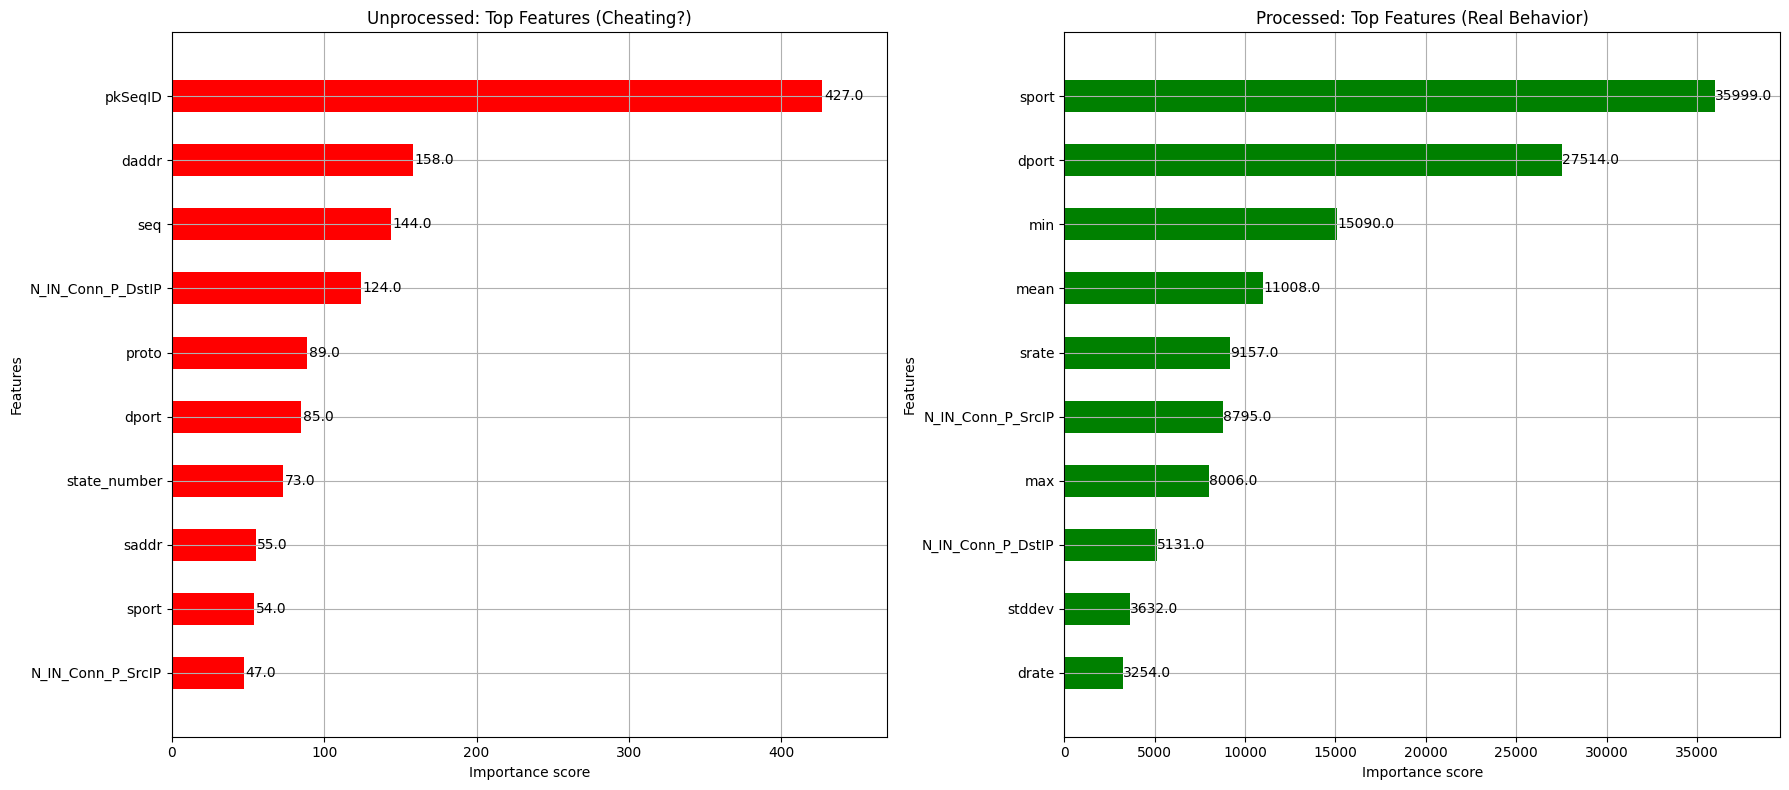

In [36]:
# This graph proves WHY the Unprocessed model was "Cheating"
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot A: Unprocessed Feature Importance
xgb.plot_importance(model_unproc, max_num_features=10, height=0.5,
                    importance_type='weight', title='Unprocessed: Top Features (Cheating?)', ax=axes[0], color='red')
# Note: You will likely see 'pkSeqID' or 'seq' at the top here.

# Plot B: Processed Feature Importance
xgb.plot_importance(best_model, max_num_features=10, height=0.5,
                    importance_type='weight', title='Processed: Top Features (Real Behavior)', ax=axes[1], color='green')
# Note: You will likely see 'N_IN_Conn_P_SrcIP' or 'mean' at the top here.

plt.tight_layout()
plt.show()

# SAVING

In [37]:
print("Saving Processed Model...")
joblib.dump(best_model, 'xgboost_model_final.joblib')
joblib.dump(le_target_proc, 'label_encoder_final.joblib')

files.download('xgboost_model_final.joblib')
files.download('label_encoder_final.joblib')

Saving Processed Model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>